In [193]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import math

assert torch.cuda.is_available()
device = 'cuda'

In [194]:
T = 1000
beta_1 = 0.0001
beta_t = 0.02

betas = torch.linspace(beta_1, beta_t, T)
alpha = 1 - betas
alpha_dash = torch.clone(alpha)

for i in range(1, T):
    alpha_dash[i] = alpha_dash[i - 1] * alpha[i]

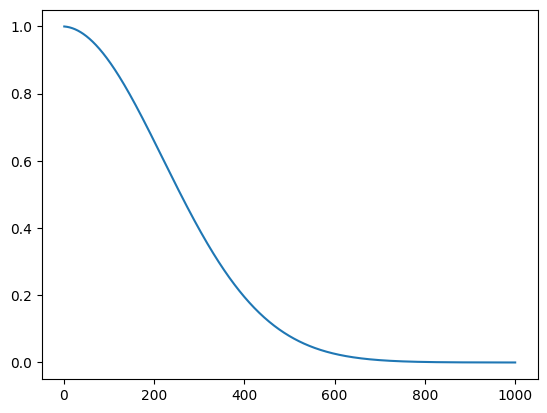

In [195]:
plt.plot(list(range(1, T + 1)), alpha_dash)

In [196]:
# alpha_dash = torch.sigmoid(torch.linspace(4, -4, 1000))
# plt.plot(
#     torch.range(1, T),
#     alpha_dash
# )

Reat the dataset

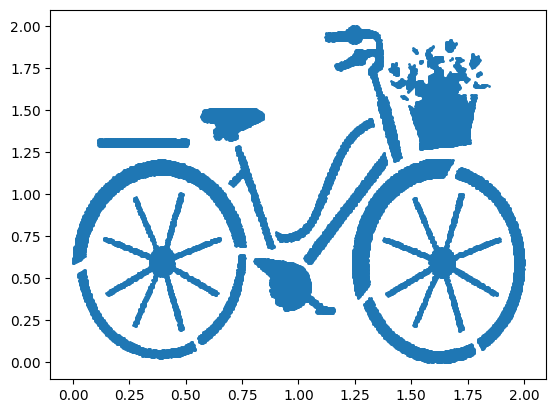

In [197]:
class BicycleDataset(Dataset):
    def __init__(self):
        with open("bicycle.txt") as file:
            lines = file.readlines()

        raw_points = [list(map(float, line.split())) for line in lines]
        self.data = [torch.tensor(point) for point in raw_points]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


dataset = BicycleDataset()
loader = DataLoader(dataset, batch_size=len(dataset))
points = next(iter(loader))
points += 1
plt.scatter(points[:, 0], points[:, 1], s=1)

In [198]:
def add_noise(points, noise, t):
    a_t = alpha_dash[t]
    return torch.sqrt(a_t) * points + torch.sqrt(torch.tensor(1) - a_t) * noise

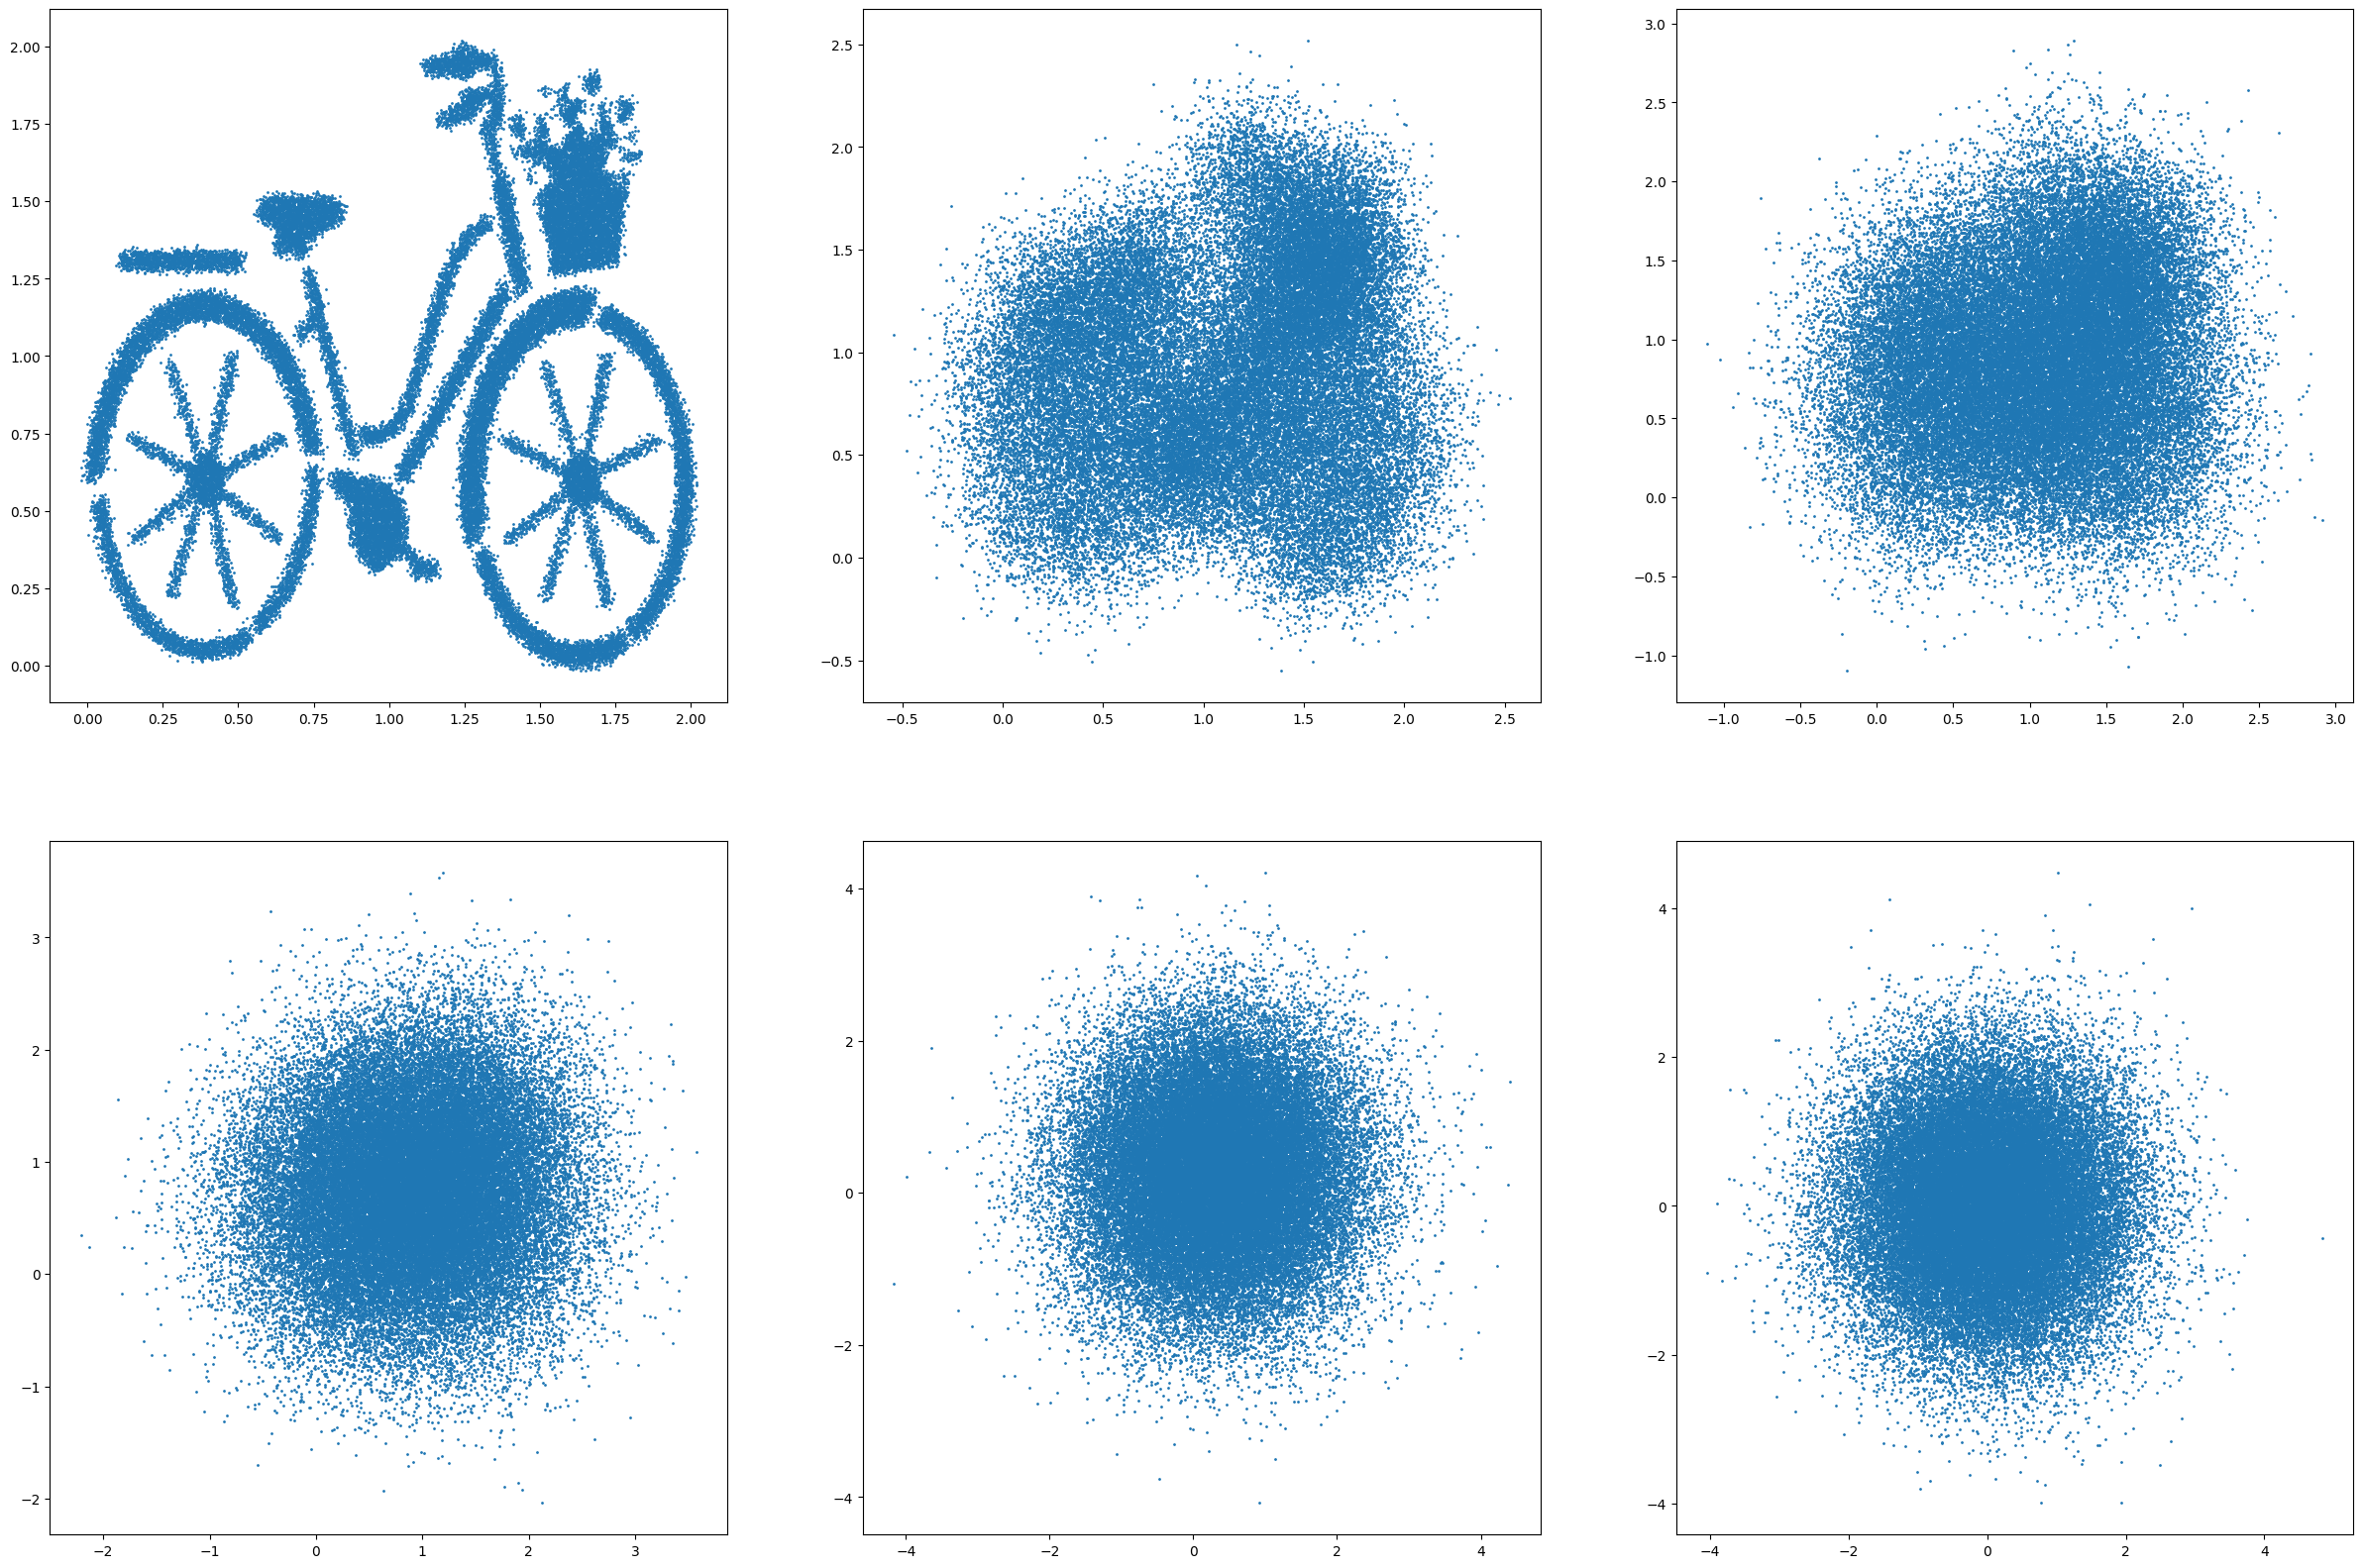

In [199]:
fix, axs = plt.subplots(2, 3, figsize=(30, 20))
for i, t in enumerate([0, 50, 100, 200, 500, 999]):
    data = torch.clone(points)
    noise = torch.randn(data.shape)
    data = add_noise(points, noise, t)
    axs[i // 3, i % 3].scatter(data[:, 0], data[:, 1], s=1)

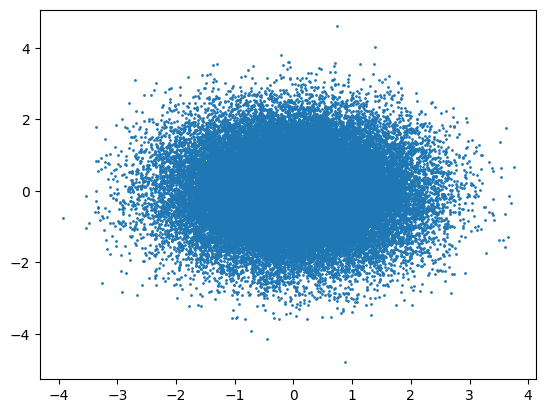

In [200]:
perfect_normal = torch.randn(points.shape)
plt.scatter(perfect_normal[:, 0], perfect_normal[:, 1], s=1)

In [201]:
# Modified from: https://gist.github.com/danimelchor/f99083a259172c37bd7098a12c2b0574


class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, max_len):
        super().__init__()
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(
            -1, 1
        )  # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(
            torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model
        )  # 1000^(2i/dim_model)

        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)

        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(self, t) -> torch.tensor:
        return self.pos_encoding[t]


p = PositionalEncoding(4, 5)
print(p(0))
p.pos_encoding

tensor([0., 1., 0., 1.])


tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992]])

In [202]:
class LearnableSinusoidalEmbedding(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.net = nn.Sequential(
            PositionalEncoding(dim_model=50, max_len=T),
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
        )

    def forward(self, t):
        return self.net(t)


class ConditionalDenseLayer(nn.Module):
    def __init__(
        self, input_size: int, output_size: int, skip_activation: bool = False
    ):
        super().__init__()
        self.x_net = nn.Linear(input_size, output_size)
        self.t_net = LearnableSinusoidalEmbedding(output_size)
        self.relu = nn.ReLU() if not skip_activation else nn.Identity()

    def forward(self, x, t):
        x = torch.add(self.x_net(x), self.t_net(t))
        x = self.relu(x)

        return x


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                ConditionalDenseLayer(2, 128),
                ConditionalDenseLayer(128, 128),
                ConditionalDenseLayer(128, 128),
                ConditionalDenseLayer(128, 2, skip_activation=True),
            ]
        )

    def forward(self, x, t):
        for layer in self.layers:
            x = layer(x, t)

        return x


x = torch.randn((5, 2))
t = torch.randint(0, T, (5,))
m = Model()
y = m(x, t)
print(y.shape)
y

torch.Size([5, 2])


tensor([[-0.1512,  0.0631],
        [ 0.1363,  0.1344],
        [ 0.2393,  0.1602],
        [ 0.0460,  0.1909],
        [-0.0180,  0.3439]], grad_fn=<AddBackward0>)

In [203]:
def add_noise(points, noise, t):
    a_t = alpha_dash[t]
    return torch.sqrt(a_t).unsqueeze(1) * points + torch.sqrt(1 - a_t).unsqueeze(1) * noise

In [207]:
epochs = 100
batch_size = 64
criterion = nn.L1Loss()

dataset = BicycleDataset()
data_loader = DataLoader(dataset, batch_size, drop_last=True, shuffle=True)

m = Model()
optimizer = torch.optim.Adam(m.parameters(), 0.0001)

for epoch in range(epochs):
    epoch_loss = 0

    for x in data_loader:
        noise = torch.randn((batch_size, 2))
        t = torch.randint(0, T, (batch_size,))

        optimizer.zero_grad()
        loss = criterion(noise, m(add_noise(x, noise, t), t))
        loss.backward()
        optimizer.step()

        epoch_loss += float(loss)

    print(f"Epoch: {epoch+1} loss: {epoch_loss / len(data_loader)}")

Epoch: 1 loss: 0.2967936309612342
Epoch: 2 loss: 0.23810920495596635
Epoch: 3 loss: 0.23554683202489984
Epoch: 4 loss: 0.2335714700107042
Epoch: 5 loss: 0.2353997925854274
Epoch: 6 loss: 0.2347585985881423
Epoch: 7 loss: 0.23246784914795518
Epoch: 8 loss: 0.23009166841957776
Epoch: 9 loss: 0.23436688196840624
Epoch: 10 loss: 0.2337086372606948
Epoch: 11 loss: 0.23192342951288683
Epoch: 12 loss: 0.23231326425589885
Epoch: 13 loss: 0.23074999080053743
Epoch: 14 loss: 0.23211725411681355
Epoch: 15 loss: 0.2338627670811215
Epoch: 16 loss: 0.23142706058200846
Epoch: 17 loss: 0.2332147662409671
Epoch: 18 loss: 0.23016918646313514
Epoch: 19 loss: 0.23172769018538714
Epoch: 20 loss: 0.2297866616946489
Epoch: 21 loss: 0.22996039431409787
Epoch: 22 loss: 0.23023692838053414
Epoch: 23 loss: 0.2307028369930795
Epoch: 24 loss: 0.22823566899913822
Epoch: 25 loss: 0.2309497812677761
Epoch: 26 loss: 0.2295086257500092
Epoch: 27 loss: 0.23009543660744494
Epoch: 28 loss: 0.23039379823707082
Epoch: 29 lo

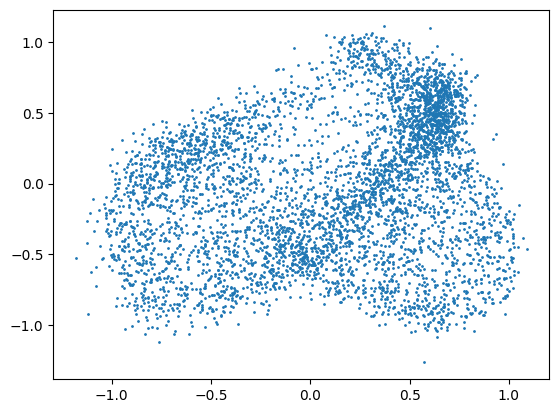

In [206]:
with torch.no_grad():
    samples = 5000
    x = torch.randn((samples, 2))
    for t in range(T - 1, -1, -1):
        z = torch.randn((samples, 2)) if t > 0 else torch.zeros((samples, 2))
        x = (
            1
            / alpha[t] ** 0.5
            * (x - (1 - alpha[t]) / (1 - alpha_dash[t]) ** 0.5 * m(x, t))
            + betas[t] ** 0.5 * z
        )
    plt.scatter(x[:, 0], x[:, 1], s=1)